#### Imports & installs

In [11]:
%%capture
! pip install sentence-transformers
! pip install polars
! pip install faiss-cpu --no-cache

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from collections import defaultdict
from termcolor import colored
import matplotlib.pyplot as plt
import polars as pl
import json
pl.Config.set_fmt_str_lengths(100)

polars.cfg.Config

In [2]:
from google.colab import drive
drive.mount("/content/drive")
ROOT = "/content/drive/MyDrive/datasets"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Read and take a look at the data

In [3]:
xl = pd.ExcelFile(f'{ROOT}/ML_test_case.xlsx')
xl.sheet_names

['Asset 1',
 'Asset 2',
 'Asset 3',
 'Asset 4',
 'Asset 5',
 'Asset 6',
 'Asset 7',
 'Asset 8',
 'Asset 9',
 'Asset 10',
 'Asset 11',
 'Asset 12']

In [4]:
xl.parse('Asset 1')

,Source Ledger Code,Source Ledger Name,Intelas Ledger Code,Intelas Ledger Name
0,1100-1001,Cash - Operating,11000-110,Cash - Operating
1,1100-1002,Cash - Clearing,11000-120,Cash - Depository / Clearing
2,1100-1003,Cash - Money Market / Other,11000-110,Cash - Operating
3,1100-1005,Cash - Money Market / Other,11000-110,Cash - Operating
4,1100-1006,Cash - Money Market / Other,11000-110,Cash - Operating
...,...,...,...,...
200,6200-4970,Gain/Loss on Insurance Proceeds,73020-140,Non-Op Insurance / Legal Claims
201,6300-5210,Professional Fees - General,73020-110,Non-Op Legal / Professional
202,6400-5450,Interest Exp - Mortgage,71000-110,Loan - Interest
203,6500-5211,Accounting & Tax Fees,62000-160,Tax Consultant / Advisor


### Merge the data and investigate if we notice something strange

In [5]:
combined_src_code, combined_dst_code = [], []
combined_src_names, combined_dst_names = [], []
combined_file_names = []

for asset in xl.sheet_names:
    df = xl.parse(asset) 
    combined_src_code.extend(df['Source Ledger Code'].to_list())
    combined_dst_code.extend(df['Intelas Ledger Code'].to_list())
    combined_src_names.extend(df['Source Ledger Name'].to_list())
    combined_dst_names.extend(df['Intelas Ledger Name'].to_list())
    combined_file_names.extend(df.shape[0] * [asset])

In [6]:
df = pl.DataFrame({
    'src_code': combined_src_code,
    'dst_code': combined_dst_code,
    'src_name': combined_src_names,
    'dst_name': combined_dst_names,
    'file_name': combined_file_names
})

In [16]:
# see if there is some data missing
df.null_count()

src_code,dst_code,src_name,dst_name,file_name
u32,u32,u32,u32,u32
617,1,0,1,0


In [7]:
# something with null value in target column could be safely dropped
df = (
    df
    .filter(
        ~pl.col('dst_name').is_null()
    )
)

In [18]:
print(f"number of rows in the dataframe: {df.shape[0]:_}")
print(f"number of unique names in Intelas taxonomy: {df['dst_name'].unique().shape[0]}")
print(f"number of unique source names: {df['src_name'].unique().shape[0]}")

number of rows in the dataframe: 2_605
number of unique names in Intelas taxonomy: 297
number of unique source names: 1089


In [10]:
number_of_same_names = (
    df
    .unique(subset='src_name')
    .filter(
        pl.col('src_name') == pl.col('dst_name')
    )
).shape[0]

number_of_different_names = (
    df
    .unique(subset='src_name')
    .filter(
        pl.col('src_name') != pl.col('dst_name')
    )
).shape[0]

In [12]:
print(f"number of same names in source and destination: {number_of_same_names:_}")
print(f"number of different names in source and destination: {number_of_different_names:_}")

number of same names in source and destination: 64
number of different names in source and destination: 1_025


### Take a look if there is ambiguity
(e.g. does the same name always map to same Itelias name) and if codes in Intelas DB have unique codes

First let's see in what cases (if any) same source names are mapped to different Intelas names

In [11]:
(
    df.groupby('src_name')
    .agg([
        pl.col('src_code').list(),
        pl.col('dst_code').list(),
        pl.col('dst_name').list(),
        pl.col('file_name').list(),
        pl.col('dst_name').unique().alias('dst_names')
    ])
    .with_column(
        pl.col('dst_names').arr.lengths().alias('num_ambiguity')
    )
    .filter(
        pl.col('num_ambiguity') >= 2
    )
    .sort('num_ambiguity', reverse=True)
).head(3)

src_name,src_code,dst_code,dst_name,file_name,dst_names,num_ambiguity
str,list[str],list[str],list[str],list[str],list[str],u32
"""Exterior Doors""","[""7007-0042"", ""1490-0042"", ""1842-0000""]","[""72030-900"", ""72000-120"", ""14000-120""]","[""Capex - General"", ""Capex - Doors"", ""Building Improvements / Additions""]","[""Asset 11"", ""Asset 11"", ""Asset 12""]","[""Capex - Doors"", ""Capex - General"", ""Building Improvements / Additions""]",3
"""Plumbing""","[""5150-5060"", ""5150-5060"", ... ""1814-0000""]","[""53000-130"", ""53000-130"", ... ""14000-120""]","[""Plumbing - Repairs"", ""Plumbing - Repairs"", ... ""Building Improvements / Additions""]","[""Asset 1"", ""Asset 2"", ... ""Asset 12""]","[""Building Improvements / Additions"", ""Plumbing - Repairs"", ""Fixed Assets - General""]",3
"""Equipment""","[""1440-1241"", ""1440-1241"", ... null]","[""14000-150"", ""14000-150"", ... ""14000-900""]","[""Furniture, Fixtures, and Equipment"", ""Furniture, Fixtures, and Equipment"", ... ""Fixed Assets - General""]","[""Asset 1"", ""Asset 2"", ... ""Asset 11""]","[""Capex - Equipment / Supplies"", ""Fixed Assets - General"", ""Furniture, Fixtures, and Equipment""]",3


Next let's see if some Intelas names are converted to same codes

In [10]:
temp = df[['dst_code', 'dst_name']].unique()
print(temp.shape[0])
(
    temp
    .groupby('dst_code')
    .agg([
        pl.col('dst_name')
    ])
    .with_columns([
        pl.col('dst_name').arr.lengths().alias('len')
    ])
    .filter(
        pl.col('len') != 1
    )
    .sort('len', reverse=True)
)

297


dst_code,dst_name,len
str,list[str],u32
"""57000-110""","[""Electric - Common Area"", ""Electric Exp - Common Areas""]",2
"""51030-900""","[""Performance Bonus - General"", ""Bonus - General""]",2
"""56010-120""","[""Fees, Dues & Subscriptions"", ""Fees / Dues / Subscriptions""]",2
"""57020-130""","[""Gas - General"", ""Gas Exp - General""]",2
"""51030-120""","[""Performance Bonus - Leasing"", ""Bonus - Leasing""]",2
"""72020-210""","[""Common Area - Interior"", ""Common Area Capex - Interior General""]",2
"""44000-260""","[""Transfer / Sublet Fee"", ""Transfer / Sublet Fee""]",2
"""57000-900""","[""Electric - General"", ""Electric Exp - General""]",2
"""57000-120""","[""Electric - Vacant Units"", ""Electric Exp - Vacant Units""]",2


We see ambiguity here.
<br>

Let's also see if there are codes ambiguity

In [11]:
(
    temp
    .groupby('dst_name')
    .agg([
        pl.col('dst_code')
    ])
    .with_columns([
        pl.col('dst_code').arr.lengths().alias('len')
    ])
    .filter(
        pl.col('len') != 1
    )
    .sort('len', reverse=True)
)

dst_name,dst_code,len
str,list[str],u32


In [13]:
# save for future use
name2code = {}

for row in temp.iter_rows(named=True):
    name2code[row['dst_name']] = row['dst_code']

with open("name2code.json", "w") as f:
    json.dump(name2code, f)

Luckily there are none

# ML Experiments

In [15]:
from sentence_transformers import SentenceTransformer, util
import torch
import faiss

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_checkpoint = "all-MiniLM-L6-v2" 
sbert = SentenceTransformer(model_checkpoint, device=device)

Helper function to compute the `Recall@1`, `Recall@3`, `Recall@5`.
This means we want to determine in what percentage of cases true Intelas name is present among top model's suggestions.

In [14]:
def compute_recall(df, predictions, top_k):
    good_predictions = 0
    for row in temp.iter_rows(named=True):
        if row['dst_name'] in predictions[row['src_name']][:top_k]:
            good_predictions += 1
    return round(good_predictions / df.shape[0] * 100, 1)

### What we get out-of-the-box

Using Sentence BERT transformer model to find similar names to map

In [15]:
# let's keep only unique names not to compute embeddings for the same strings multiple times
dst_names = df['dst_name'].unique().to_numpy()
src_names = df['src_name'].unique().to_numpy()

In [16]:
src_encodings = sbert.encode(
        src_names,
        show_progress_bar=True,
        convert_to_tensor=False,
        batch_size=64,
)

Batches:   0%|          | 0/18 [00:00<?, ?it/s]

In [158]:
dst_encodings = sbert.encode(
        dst_names,
        show_progress_bar=True,
        convert_to_tensor=False,
        batch_size=64,
)

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

In [159]:
# we index Intelas taxonomy to later conduct the search against those predefined values
d = dst_encodings.shape[1]
index = faiss.IndexFlatL2(d)
index.add(dst_encodings)

In [160]:
# Let's take a look at top 5 predictions per source name
k = 10
D, I = index.search(src_encodings, k)

Let's parse our predictions

In [161]:
predictions = {}
for id_ in range(len(src_names)):
    predictions[src_names[id_]] = dst_names[I[id_]]

In [162]:
print(f"Recall@1: {compute_recall(df, predictions, 1)}%")
print(f"Recall@3: {compute_recall(df, predictions, 2)}%")
print(f"Recall@3: {compute_recall(df, predictions, 3)}%")
print(f"Recall@5: {compute_recall(df, predictions, 5)}%")

Recall@1: 48.8%
Recall@3: 58.9%
Recall@3: 64.3%
Recall@5: 69.7%


Not too bad, as this is what we got without training anything and without really investigating the data, but let's see if we can make it better

### Imporovement

Let's take a look at mistakes which the model makes:

In [154]:
name2code = {}
code2name = {}
for row in df[['dst_name', 'dst_code']].unique().iter_rows(named=True):
    name2code[row['dst_name']] = int(row['dst_code'].replace("-", ""))
    code2name[int(row['dst_code'].replace("-", ""))] = row['dst_name']

In [163]:
# we already have our predictions
num_to_print = 20
for i, row in enumerate(df.iter_rows(named=True)):
    pred = predictions[row['src_name']]
    if row['dst_name'] != pred[0]:
        print(tabulate([[f"query: {row['src_name']}", f"{row['src_code']}"],
                        [f"true_val: {row['dst_name']}", f"{row['dst_code']}"],
                        [f"pred_1: {pred[0]}", f"{name2code[pred[0]]}"],
                        [f"pred_2: {pred[1]}", f"{name2code[pred[1]]}"],
                        [f"pred_3 {pred[2]}", f"{name2code[pred[2]]}"],
                       ]))
        print()
        num_to_print -= 1
    if num_to_print == 0:
        break

---------------------------------  ---------
query: Cash - Borrowers Acct       1100-1007
true_val: Cash - Operating         11000-110
pred_1: Restricted Cash - General  11100900
pred_2: Cash - Operating           11000110
pred_3 Loan Payable 3              22000130
---------------------------------  ---------

---------------------------------------------  ---------
query: Tenant's Security Deposits              1110-1070
true_val: Restricted Cash - Security Deposits  11100-110
pred_1: Security Deposit Liability             21020120
pred_2: Restricted Cash - Security Deposits    11100110
pred_3 Deposit Forfeitures                     44010110
---------------------------------------------  ---------

-----------------------------------------  ---------
query: Escrow - Real Estate Taxes          1110-1071
true_val: Restricted Cash - Tax Escrow     11100-120
pred_1: Real Estate Taxes                  62000110
pred_2: Restricted Cash - Tax Escrow       11100120
pred_3 Restricted Cash - In

When we take a look we see that codes of Intelas internal taxonomy tend to be close the source codes if different ledgers, which sound logical. Let's take a closer look at this

#### Investigating codes

Let's see how the codes in source files correlate to the codes in Intelas taxonomy. 
We can see that codes are sometimes of different lengths. Let's fill them with zeros to contain 6 digits

For the sake of this analysis let's use the difference in terms of tens (counting 2 first numbers). So that code "4003-0000" will become `40,03` in our analysis and "72020-210" will become `72,020210` etc.

In [174]:
df = (
    df
    .with_columns([
        pl.col('src_code').str.replace("-", "")
            .apply(lambda x: x.ljust(8, '0'))
            .cast(int)
            .alias('src_code_norm'),

        pl.col('dst_code').str.replace("-", "").cast(int).alias('dst_code_norm')
    ])
    .with_columns([
        ((pl.col('src_code_norm') - pl.col('dst_code_norm')) / 10 ** 6).map(abs).alias('code_diff')
    ])
    .sort('code_diff', reverse=True)
)

In [165]:
df.sample(3)

src_code,dst_code,src_name,dst_name,file_name,src_code_norm,dst_code_norm,code_diff
str,str,str,str,str,i64,i64,f64
"""6311-0000""","""56000-130""","""Office Supplies""","""Office Supplies""","""Asset 11""",63110000,56000130,7.10987
"""1300-1127""","""13000-110""","""Prepaid Insurance""","""Prepaid - Insurance""","""Asset 4""",13001127,13000110,0.001017
null,"""51040-110""","""ER FICA Expense""","""Payroll Taxes""","""Asset 9""",null,51040110,null


Let's visualize those differences to see the trends more easily

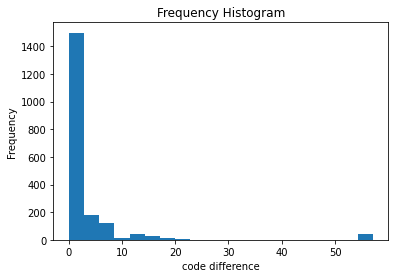

In [166]:
code_diffs = [el for el in df['code_diff'].to_list() if el]
plt.hist(code_diffs, bins=20);
plt.gca().set(title='Frequency Histogram', ylabel='Frequency', xlabel='code difference');

We can see that codes are almost never different by more than 10. This is a strong indicator as to where to look for the Intelas internal taxonomy name if the source code is given.

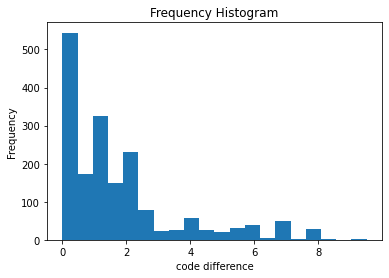

In [167]:
# let's investigate more closely the range between 1..10
code_diffs = [el for el in df['code_diff'].to_list() if el and el < 10]
plt.hist(code_diffs, bins=20);
plt.gca().set(title='Frequency Histogram', ylabel='Frequency', xlabel='code difference');

Here we see that most common differences and less than 3. 

Let's see how this knowledge can help us

First let's see if we get better metrics if we look for candidates inside the groups of codes which are at some threshold distance apart from the source_code if this source_code is provided

In [175]:
# as we are going to reuse embedding of the names
dst_names = df['dst_name'].unique().to_list()
src_names = df['src_name'].unique().to_list()
all_names = list(set(dst_names + src_names))
names_encodings = sbert.encode(
        all_names,
        show_progress_bar=True,
        convert_to_tensor=False,
        batch_size=64,
)
name2encoding = {name:enc for name, enc in zip(all_names, names_encodings)}

Batches:   0%|          | 0/21 [00:00<?, ?it/s]

In [176]:
dst_names = np.array(dst_names)
dst_encodings = sbert.encode(
        dst_names,
        show_progress_bar=True,
        convert_to_tensor=False,
        batch_size=64,
)
d = dst_encodings.shape[1]
index = faiss.IndexFlatL2(d)
index.add(dst_encodings)

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

In [178]:
k = 5
for j in range(2, 20):
    asnwer_belongs_to_range = 0
    range_exists = 0
    num_true_predictions = 0
    predictions = {}
    for row in df.iter_rows(named=True):
        query_enc = name2encoding[row['src_name']]
        if row['src_code_norm']:
            start = row['src_code_norm'] - j * 10**6
            end = row['src_code_norm'] + j * 10**6
            candidates = []
            for code in code2name:
                if code >= start and code <= end:
                    candidates.append(code2name[code])
            candidates = np.array(candidates)
            
            if candidates.size != 0:
                cands_enc = np.array([name2encoding[name] for name in candidates])

                similarities = util.cos_sim(query_enc, cands_enc)[0].numpy()

                curr_k = min(k, len(candidates))
                ind = np.argpartition(
                        similarities, 
                        -curr_k
                      )[-curr_k:]

                indexes = ind[np.argsort(similarities[ind])][::-1]
                
                if row['dst_name'] in candidates:
                    asnwer_belongs_to_range += 1
                range_exists += 1
                predictions[row['src_name']] = candidates[indexes[:k]]

            else:
                D, I = index.search(np.expand_dims(query_enc, axis=0), k)
                predictions[row['src_name']] = dst_names[I[0]]

        else:
            D, I = index.search(np.expand_dims(query_enc, axis=0), k)
            predictions[row['src_name']] = dst_names[I[0]]

    ratio = round(asnwer_belongs_to_range / range_exists * 100, 2)
    print(f"Code distance in our system ± {j}")
    print(f"the correct dst_name belongs to the range if the range exists in {ratio}% cases")
    print(f"Recall@1: {compute_recall(df, predictions,1)}%")
    print(f"Recall@3: {compute_recall(df, predictions,2)}%")
    print(f"Recall@3: {compute_recall(df, predictions,3)}%")
    print(f"Recall@5: {compute_recall(df, predictions,5)}%")
    print("-"*80)

Code distance in our system ± 2
the right name belongs to the range if the range exists in 67.5% cases
Recall@1: 44.6%
Recall@3: 51.2%
Recall@3: 56.4%
Recall@5: 61.7%
--------------------------------------------------------------------------------
Code distance in our system ± 3
the right name belongs to the range if the range exists in 75.96% cases
Recall@1: 47.3%
Recall@3: 54.6%
Recall@3: 59.9%
Recall@5: 64.7%
--------------------------------------------------------------------------------
Code distance in our system ± 4
the right name belongs to the range if the range exists in 78.94% cases
Recall@1: 48.1%
Recall@3: 55.4%
Recall@3: 60.8%
Recall@5: 65.8%
--------------------------------------------------------------------------------
Code distance in our system ± 5
the right name belongs to the range if the range exists in 82.14% cases
Recall@1: 48.9%
Recall@3: 56.1%
Recall@3: 61.3%
Recall@5: 66.6%
--------------------------------------------------------------------------------
Code 

As we can see from the statistics above we can increase the metrics by setting the number of codes to look though (if the code exists) by ±8 threshold from `48.8` to `51.2`

Improvement is not that big, but we just used a simple heuristic.

#### Let's try training the model

From my experience I can say that we need at least 10k pairs for model to become better than the general models available on  https://www.sbert.net/index.html

But let's make sure of it and do a training with 5 fold cross validation (each time training on 4/5 of the dataset and validation on left over 1/5) to make the comparison fair on such a small dataset (only ~1k pairs)

In [14]:
from torch.utils.data import DataLoader
import itertools
import torch
from sklearn.model_selection import KFold
from sentence_transformers.readers import InputExample
from sentence_transformers import models, losses, SentenceTransformer
import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.WARNING)

In [15]:
from sentence_transformers.evaluation import SentenceEvaluator
import logging
from sentence_transformers.util import paraphrase_mining
import os
import csv
import IPython.display as disp
from typing import List, Tuple, Dict
from collections import defaultdict

##### ParaphraseMiningEvaluator

In [16]:
def text_to_html_table(items):
    "Put the texts in `items` in an HTML table."
    html_code = """<table border="1" class="dataframe">\n"""
    html_code += """  <thead>\n <tr style="text-align: left;">\n"""
    for i in items[0]:
        html_code += f"      <th>{i}</th>\n"
    html_code += "    </tr>\n  </thead>\n  <tbody>\n"
    for line in items[1:]:
        html_code += "    <tr>\n"
        for elt in line:
            elt = f"{elt:.6f}" if isinstance(elt, float) else str(elt)
            html_code += f"      <td>{elt}</td>\n"
        html_code += "    </tr>\n"
    html_code += "  </tbody>\n</table><p>"
    return html_code

In [17]:
class ParaphraseMiningEvaluator(SentenceEvaluator):

    def __init__(self, sentences_map: Dict[str, str], duplicates_list: List[Tuple[str, str]] = None, duplicates_dict: Dict[str, Dict[str, bool]] = None, add_transitive_closure: bool = False, query_chunk_size:int = 5000, corpus_chunk_size:int = 100000, max_pairs: int = 500000, top_k: int = 100, show_progress_bar: bool = False, batch_size: int = 16, name: str = '', write_csv: bool = True):
        
        self.sentences = []
        self.ids = []
        self.items = []
        self.output = None

        for id, sentence in sentences_map.items():
            self.sentences.append(sentence)
            self.ids.append(id)

        self.name = name
        self.show_progress_bar = show_progress_bar
        self.batch_size = batch_size
        self.query_chunk_size = query_chunk_size
        self.corpus_chunk_size = corpus_chunk_size
        self.max_pairs = max_pairs
        self.top_k = top_k

        self.duplicates = duplicates_dict if duplicates_dict is not None else defaultdict(lambda: defaultdict(bool))
        if duplicates_list is not None:
            for id1, id2 in duplicates_list:
                if id1 in sentences_map and id2 in sentences_map:
                    self.duplicates[id1][id2] = True
                    self.duplicates[id2][id1] = True


        #Add transitive closure
        if add_transitive_closure:
            self.duplicates = self.add_transitive_closure(self.duplicates)


        positive_key_pairs = set()
        for key1 in self.duplicates:
            for key2 in self.duplicates[key1]:
                if key1 in sentences_map and key2 in sentences_map and (self.duplicates[key1][key2] or self.duplicates[key2][key1]):
                    positive_key_pairs.add(tuple(sorted([key1, key2])))

        self.total_num_duplicates = len(positive_key_pairs)

        if name:
            name = "_" + name

        self.csv_file: str = "paraphrase_mining_evaluation" + name + "_results.csv"
        self.csv_headers = ["epoch", "steps", "precision", "recall", "f1", "threshold", "average_precision"]
        self.write_csv = write_csv

    def __call__(self, model, output_path: str = None, epoch: int = -1, steps: int = -1) -> float:
        if epoch != -1:
            out_txt = f" after epoch {epoch}:" if steps == -1 else f" in epoch {epoch} after {steps} steps:"
        else:
            out_txt = ":"

        #Compute embedding for the sentences
        pairs_list = paraphrase_mining(model, self.sentences, self.show_progress_bar, self.batch_size,  self.query_chunk_size,  self.corpus_chunk_size, self.max_pairs, self.top_k )

        #Compute F1 score and Average Precision
        n_extract = n_correct = 0
        threshold = 0
        best_f1 = best_recall = best_precision = 0

        average_precision = 0

        for idx in range(len(pairs_list)):
            score, i, j = pairs_list[idx]
            id1 = self.ids[i]
            id2 = self.ids[j]

            #Compute optimal threshold and F1-score
            n_extract += 1
            if self.duplicates[id1][id2] or self.duplicates[id2][id1]:
                n_correct += 1
                precision = n_correct / n_extract
                recall = n_correct / self.total_num_duplicates
                f1 = 2 * precision * recall / (precision + recall)
                average_precision += precision
                if f1 > best_f1:
                    best_f1 = f1
                    best_precision = precision
                    best_recall = recall
                    threshold = (pairs_list[idx][0] + pairs_list[min(idx + 1, len(pairs_list)-1)][0]) / 2

        average_precision = average_precision / self.total_num_duplicates
        if not self.items:
            self.items.append(["Epoch", "Steps", "Precision", "Recall", "F1"])
        self.items.append([epoch+1, steps, best_precision * 100,
                      best_recall * 100, best_f1 * 100])

        html_code = text_to_html_table(self.items)
        if self.output is None:
            self.output = disp.display(disp.HTML(html_code), display_id=True)
        else:
            self.output.update(disp.HTML(html_code))
        if output_path is not None and self.write_csv:
            csv_path = os.path.join(output_path, self.csv_file)
            if not os.path.isfile(csv_path):
                with open(csv_path, newline='', mode="w", encoding="utf-8") as f:
                    writer = csv.writer(f)
                    writer.writerow(self.csv_headers)
                    writer.writerow([epoch, steps, best_precision, best_recall, best_f1, threshold, average_precision])
            else:
                with open(csv_path, newline='', mode="a", encoding="utf-8") as f:
                    writer = csv.writer(f)
                    writer.writerow([epoch, steps, best_precision, best_recall, best_f1, threshold, average_precision])

        return average_precision


    @staticmethod
    def add_transitive_closure(graph):
        nodes_visited = set()
        for a in list(graph.keys()):
            if a not in nodes_visited:
                connected_subgraph_nodes = set()
                connected_subgraph_nodes.add(a)

                # Add all nodes in the connected graph
                neighbor_nodes_queue = list(graph[a])
                while len(neighbor_nodes_queue) > 0:
                    node = neighbor_nodes_queue.pop(0)
                    if node not in connected_subgraph_nodes:
                        connected_subgraph_nodes.add(node)
                        neighbor_nodes_queue.extend(graph[node])

                # Ensure transitivity between all nodes in the graph
                connected_subgraph_nodes = list(connected_subgraph_nodes)
                for i in range(len(connected_subgraph_nodes) - 1):
                    for j in range(i + 1, len(connected_subgraph_nodes)):
                        graph[connected_subgraph_nodes[i]][connected_subgraph_nodes[j]] = True
                        graph[connected_subgraph_nodes[j]][connected_subgraph_nodes[i]] = True

                        nodes_visited.add(connected_subgraph_nodes[i])
                        nodes_visited.add(connected_subgraph_nodes[j])
        return graph

##### Training

In [18]:
# for the sake of this analysis let's keep only unique values
temp = (
    df
    .unique(subset=['src_name', 'dst_name'])
)

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
def train_model(train_df, test_df):
    train_examples = []

    for row in train_df.iter_rows(named=True):
        train_examples.append(InputExample(texts=[row['src_name'], row['dst_name']]))

    prev, i = 0, 0
    sentences_map, duplicates_list = {}, []
    for row in test_df.iter_rows(named=True):
        sentences_map[str(i)] = row['src_name']
        i += 1
        sentences_map[str(i)] = row['dst_name']
        i += 1
        duplicates_list += list(itertools.combinations([str(el) for el in range(prev, i)],2))
        prev = i
    # load model
    model = SentenceTransformer("all-MiniLM-L6-v2", device=device)
    train_loss = losses.MultipleNegativesRankingLoss(model=model)
    train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
    evaluator = ParaphraseMiningEvaluator(sentences_map, duplicates_list)
    model.fit(
          train_objectives=[(train_dataloader,train_loss)],
          evaluation_steps=50,
          evaluator=evaluator, 
          optimizer_params = {'lr': 1e-5},
          output_path="model",
          epochs=8, warmup_steps=50,
    )
    return model

In [21]:
kfold = KFold(n_splits=5, random_state=42, shuffle=True)

file_names = temp['file_name'].unique().to_numpy()
batch_size=16
predictions_trained_model = {}

for i, (train_idx, test_idx) in tqdm(list(enumerate(
                kfold.split(file_names)
            ))):
    train_files = file_names[train_idx]
    test_files = file_names[test_idx]

    train_df = (
        temp
        .filter(
            pl.col('file_name').is_in(train_files.tolist())
        )
    )
    test_df = (
        temp
        .filter(
            pl.col('file_name').is_in(test_files.tolist())
        )
    )

    model = train_model(train_df, test_df)

    fold_src_names = test_df['src_name'].to_numpy()
    dst_names = temp['dst_name'].to_numpy()

    fold_src_encodings = model.encode(fold_src_names)
    dst_encodings =  model.encode(dst_names)

    d = dst_encodings.shape[1]
    index = faiss.IndexFlatL2(d)
    index.add(dst_encodings)
    k = 10
    D, I = index.search(fold_src_encodings, k)
    predicted_mappings = {}
    for id_ in range(len(fold_src_names)):
        predicted_mappings[fold_src_names[id_]] = dst_names[I[id_]]

    predictions_trained_model = {**predictions_trained_model, **predicted_mappings}

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Iteration:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch,Steps,Precision,Recall,F1
1,50,7.320540,44.396552,12.568639
1,-1,7.431874,38.793103,12.474012
2,50,7.189015,38.362069,12.108844
2,-1,7.377778,35.775862,12.232867
3,50,7.550483,37.068966,12.545587
3,-1,7.597173,37.068966,12.609971
4,50,7.618214,37.500000,12.663755
4,-1,7.436096,41.379310,12.606697
5,50,7.698888,38.793103,12.847966
5,-1,7.666941,40.086207,12.871972


Iteration:   0%|          | 0/58 [00:00<?, ?it/s]

Iteration:   0%|          | 0/58 [00:00<?, ?it/s]

Iteration:   0%|          | 0/58 [00:00<?, ?it/s]

Iteration:   0%|          | 0/58 [00:00<?, ?it/s]

Iteration:   0%|          | 0/58 [00:00<?, ?it/s]

Iteration:   0%|          | 0/58 [00:00<?, ?it/s]

Iteration:   0%|          | 0/58 [00:00<?, ?it/s]

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Iteration:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch,Steps,Precision,Recall,F1
1,50,7.894737,17.355372,10.852713
1,-1,7.792208,17.355372,10.755442
2,50,7.240705,15.289256,9.827357
2,-1,7.321773,15.702479,9.986859
3,50,6.511628,23.140496,10.163339
3,-1,6.524184,23.966942,10.256410
4,50,6.437292,23.966942,10.148731
4,-1,6.311208,23.966942,9.991387
5,50,6.243603,25.206612,10.008203
5,-1,6.451613,23.140496,10.090090


Iteration:   0%|          | 0/57 [00:00<?, ?it/s]

Iteration:   0%|          | 0/57 [00:00<?, ?it/s]

Iteration:   0%|          | 0/57 [00:00<?, ?it/s]

Iteration:   0%|          | 0/57 [00:00<?, ?it/s]

Iteration:   0%|          | 0/57 [00:00<?, ?it/s]

Iteration:   0%|          | 0/57 [00:00<?, ?it/s]

Iteration:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Iteration:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch,Steps,Precision,Recall,F1
1,50,10.856454,47.368421,17.664377
1,-1,11.111111,43.684211,17.716115
2,50,11.420613,43.157895,18.061674
2,-1,11.484594,43.157895,18.141593
3,50,11.543811,43.684211,18.261826
3,-1,11.576011,43.684211,18.302095
4,50,11.138924,46.842105,17.997978
4,-1,11.167513,46.315789,17.995910
5,50,11.137441,49.473684,18.181818
5,-1,11.369509,46.315789,18.257261


Iteration:   0%|          | 0/60 [00:00<?, ?it/s]

Iteration:   0%|          | 0/60 [00:00<?, ?it/s]

Iteration:   0%|          | 0/60 [00:00<?, ?it/s]

Iteration:   0%|          | 0/60 [00:00<?, ?it/s]

Iteration:   0%|          | 0/60 [00:00<?, ?it/s]

Iteration:   0%|          | 0/60 [00:00<?, ?it/s]

Iteration:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Iteration:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch,Steps,Precision,Recall,F1
1,50,12.585034,36.097561,18.663304
1,-1,12.171053,36.097561,18.204182
2,50,11.795775,32.682927,17.335058
2,-1,12.248629,32.682927,17.819149
3,50,12.550607,30.243902,17.739628
3,-1,12.798265,28.780488,17.717718
4,50,12.217195,39.512195,18.663594
4,-1,12.235650,39.512195,18.685121
5,50,12.909441,32.682927,18.508287
5,-1,12.737643,32.682927,18.331053


Iteration:   0%|          | 0/59 [00:00<?, ?it/s]

Iteration:   0%|          | 0/59 [00:00<?, ?it/s]

Iteration:   0%|          | 0/59 [00:00<?, ?it/s]

Iteration:   0%|          | 0/59 [00:00<?, ?it/s]

Iteration:   0%|          | 0/59 [00:00<?, ?it/s]

Iteration:   0%|          | 0/59 [00:00<?, ?it/s]

Iteration:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Iteration:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch,Steps,Precision,Recall,F1
1,50,6.595174,44.244604,11.479235
1,-1,6.599255,44.604317,11.497450
2,50,6.437768,48.561151,11.368421
2,-1,6.425121,47.841727,11.328790
3,50,25.000000,9.712230,13.989637
3,-1,6.488749,44.604317,11.329374
4,50,6.514477,42.086331,11.282546
4,-1,6.525376,42.086331,11.298889
5,50,6.473684,44.244604,11.294766
5,-1,28.846154,10.791367,15.706806


Iteration:   0%|          | 0/55 [00:00<?, ?it/s]

Iteration:   0%|          | 0/55 [00:00<?, ?it/s]

Iteration:   0%|          | 0/55 [00:00<?, ?it/s]

Iteration:   0%|          | 0/55 [00:00<?, ?it/s]

Iteration:   0%|          | 0/55 [00:00<?, ?it/s]

Iteration:   0%|          | 0/55 [00:00<?, ?it/s]

Iteration:   0%|          | 0/55 [00:00<?, ?it/s]

We can already see that the metrics actually go down and not up, which indicates that the model is forgetting the good knowledge and overfitting. Let's see how much training on such a small dataset worsened the prediction quality

In [22]:
def compute_recall(df, predictions, top_k):
    good_predictions = 0
    for row in temp.iter_rows(named=True):
        if row['dst_name'] in predictions[row['src_name']][:top_k]:
            good_predictions += 1
    return round(good_predictions / df.shape[0] * 100, 1)

In [23]:
print(f"Recall@1: {compute_recall(temp, predictions_trained_model,1)}%")
print(f"Recall@3: {compute_recall(temp, predictions_trained_model,2)}%")
print(f"Recall@3: {compute_recall(temp, predictions_trained_model,3)}%")
print(f"Recall@5: {compute_recall(temp, predictions_trained_model,5)}%")
print(f"Recall@5: {compute_recall(temp, predictions_trained_model,10)}%")

Recall@1: 44.9%
Recall@3: 47.3%
Recall@3: 50.2%
Recall@5: 56.7%
Recall@5: 65.4%


Now let's see how general model performs on this "deduplicated" dataset

In [27]:
# no training
src_names = temp['src_name'].to_numpy()
dst_names = temp['dst_name'].to_numpy()

src_encodings = model.encode(src_names)
dst_encodings =  model.encode(dst_names)

d = dst_encodings.shape[1]
index = faiss.IndexFlatL2(d)
index.add(dst_encodings)
k = 10
D, I = index.search(src_encodings, k)
predictions_general_model = {}
for id_ in range(len(src_names)):
    predictions_general_model[src_names[id_]] = dst_names[I[id_]]

In [28]:
print(f"Recall@1: {compute_recall(temp, predictions_general_model,1)}%")
print(f"Recall@3: {compute_recall(temp, predictions_general_model,2)}%")
print(f"Recall@3: {compute_recall(temp, predictions_general_model,3)}%")
print(f"Recall@5: {compute_recall(temp, predictions_general_model,5)}%")
print(f"Recall@5: {compute_recall(temp, predictions_general_model,10)}%")

Recall@1: 49.2%
Recall@3: 52.4%
Recall@3: 55.6%
Recall@5: 62.4%
Recall@5: 71.5%


As we see general model performs better, as we expected, since general model was trained on !B sentence pairs which makes it very robust. For owr use-case I would suggest expanding the dataset and training a backbone model unsupervised on the domain-specific sentences.

# Future improvement

As we discovered, there is strong correlation between the source code and Intelas code (when this code is present). So future model will definitely benefit from getting this information

Suggested architecture for training:
* Embedder for the code (just first 2 letters as they seem to be the most informative and plus there are not so many possibilities of those.
* Embedder for phrases (SBERT model).


We make all the weights trainable and add embeddings and than train model in the setting in which it should project the code + name from the source file nea the projection of the name of our internal taxonomy in vector space.

From my experience for this to work well we need at least 10k pairs. Otherwise the model will just overfit and ot's better to use a general one if there is not enough data.
